In [1]:
import os
import sys
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option("display.max_columns", 200)
from tqdm import tqdm
tqdm.pandas()

In [2]:
TOP_BODY_PARTS = {"Nose": 0, "REye": 14, "LEye": 15, }
BOTTOM_BODY_PARTS = {"RAnkle": 10, "LAnkle": 13}
NETWORK = cv2.dnn.readNetFromTensorflow("./models/graph_opt.pb")

THRESHOLD = 0.45
REQUIRED_OUTPUTS = list(TOP_BODY_PARTS.values())
REQUIRED_OUTPUTS_FULL = list(TOP_BODY_PARTS.values()) + list(BOTTOM_BODY_PARTS.values())

In [5]:
def isFrontFacing(image: np.ndarray) -> bool:
    "Detect if it's Front Facing Image or not, depending on if image has either Eye, Nose"
    NETWORK.setInput(cv2.dnn.blobFromImage(image, 1.0, (368, 368), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = NETWORK.forward()[:, REQUIRED_OUTPUTS_FULL, :, :]
    top = False
    for i in range(0,3):
        heatMap = out[0, i, :, :]
        _, confidence, _, _ = cv2.minMaxLoc(heatMap)
        if confidence > THRESHOLD:
            top = True
            break
    return top

In [15]:
def isFrontOrFullPose(image: np.ndarray) -> (bool):
    "Detect if it's Full Pose or not, depending on if image has either Eye, Nose along with one of the Ankle Key points"
    
    NETWORK.setInput(cv2.dnn.blobFromImage(image, 1.0, (368, 368), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = NETWORK.forward()[:, REQUIRED_OUTPUTS_FULL, :, :]
    top, bottom = False, False
    
    for i in range(0,3):
        heatMap = out[0, i, :, :]
        _, confidence, _, _ = cv2.minMaxLoc(heatMap)
        if confidence > THRESHOLD:
            top = True
            break
    
    for i in range(3,5):
        heatMap = out[0, i, :, :]
        _, confidence, _, _ = cv2.minMaxLoc(heatMap)
        if confidence > THRESHOLD:
            bottom = True
            break
            
    return top or (top and bottom)

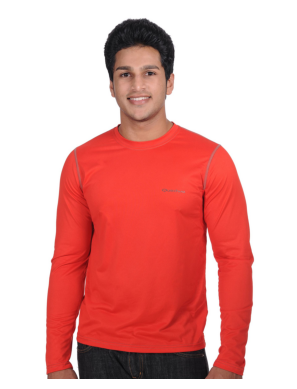

In [16]:
SAMPLE_TEST_IMG = "./models/sample.jpg"

img = cv2.imread(SAMPLE_TEST_IMG)
img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis(False);

In [17]:
estPose = isFrontOrFullPose(img)
print(f"Is Front Facing or Full Pose? {estPose}")

Is Front Facing or Full Pose? True


In [19]:
%%timeit
isFrontOrFullPose(img)

174 ms ± 6.78 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
